C:\Users\Acer\AppData\Local\Temp\ipykernel_36568\3975173606.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


                       PM2_5
time                        
2024-01-01 00:00:00  16.8070
2024-01-01 01:00:00  14.2312
2024-01-01 02:00:00  13.7509
2024-01-01 03:00:00  19.9360
2024-01-01 04:00:00  25.5151
ADF Statistic: -4.7240737073995795
P-Value: 7.581315538056673e-05


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              PM2_5   No. Observations:                 9864
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -33904.853
Date:                            Sun, 16 Mar 2025   AIC                          67819.706
Time:                                    19:02:17   BIC                          67855.677
Sample:                                         0   HQIC                         67831.892
                                           - 9864                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5277      0.009     57.904      0.000       0.510       0.546
ma.L1         -0.8078      0.007   

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Acer\AppData\Local\Temp\ipykernel_36568\3975173606.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=df.index[-1], periods=7, freq="H")[1:]  # กำหนดเวลาใหม่ 6 ชั่วโมงถัดไป


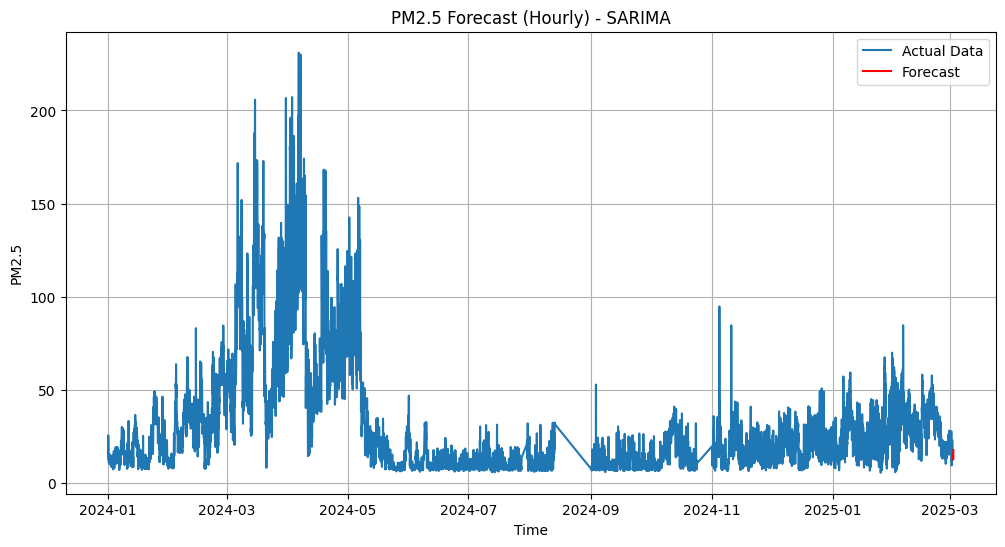

In [1]:
import pymysql
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1️⃣ เชื่อมต่อกับฐานข้อมูล MySQL
conn = pymysql.connect(
    host='localhost',        # เปลี่ยนเป็น host ของฐานข้อมูล
    user='root',             # เปลี่ยนเป็น user ของฐานข้อมูล
    password='',             # เปลี่ยนเป็น password ของฐานข้อมูล
    database='air'           # เปลี่ยนเป็นชื่อฐานข้อมูล
)

# 2️⃣ ดึงข้อมูลจากตาราง data_imt โดยใช้คอลัมน์ time และ PM2_5
query = "SELECT time, PM2_5 FROM data_imt ORDER BY time ASC"
df = pd.read_sql(query, conn)
conn.close()

# 3️⃣ แปลงคอลัมน์ time เป็น datetime และตั้งเป็น index
df['time'] = pd.to_datetime(df['time'])  # แปลงคอลัมน์ time เป็น datetime
df.set_index('time', inplace=True)        # ตั้งคอลัมน์ time เป็น index

# 4️⃣ แสดงข้อมูลเบื้องต้น
print(df.head())  # แสดงข้อมูล 5 แถวแรก

# 5️⃣ ตรวจสอบความเป็น Stationary ด้วย ADF Test
result = adfuller(df['PM2_5'])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

# ถ้า p-value > 0.05 แสดงว่าข้อมูลไม่เป็น stationary -> ทำ Differencing
if result[1] > 0.05:
    df['PM2_5_diff'] = df['PM2_5'].diff().dropna()  # ทำ Differencing
    df['PM2_5_diff'].plot(figsize=(12, 6), title="Differenced PM2.5")
    plt.show()

# 6️⃣ สร้างโมเดล SARIMA (p=1, d=1, q=1)(P=1, D=1, Q=1, m=24)
model = SARIMAX(df['PM2_5'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # 24 ชั่วโมงเป็นฤดูกาล
model_fit = model.fit()

# 7️⃣ แสดงผลการสรุปโมเดล
print(model_fit.summary())

# 8️⃣ พยากรณ์ค่า PM2.5 ในอนาคต (6 ชั่วโมงข้างหน้า)
forecast = model_fit.forecast(steps=6).round(2)  # ปัดค่าทศนิยม 2 ตำแหน่ง

# 9️⃣ แสดงเวลาที่พยากรณ์ออกมา
forecast_times = pd.date_range(start=df.index[-1], periods=7, freq="H")[1:]  # กำหนดเวลาใหม่ 6 ชั่วโมงถัดไป

# สร้าง DataFrame เพื่อแสดงผล พร้อมปัดค่าฝุ่นเป็นทศนิยม 2 ตำแหน่ง
forecast_df = pd.DataFrame({
    'Timestamp': forecast_times,  # ใช้ time ที่พยากรณ์
    'Forecasted PM2.5': forecast  # ค่า PM2.5 ที่พยากรณ์
})

# ปริ้นค่าฝุ่นและเวลา
print(forecast_df)

# 10️⃣ แสดงกราฟการพยากรณ์ (เป็นรายชั่วโมง)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PM2_5'], label="Actual Data")  # ข้อมูลจริง
plt.plot(forecast_times, forecast, label="Forecast", color='red')  # การพยากรณ์
plt.legend()
plt.title("PM2.5 Forecast (Hourly) - SARIMA")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.grid()
plt.show()

# 11️⃣ เชื่อมต่อฐานข้อมูล MySQL สำหรับเก็บข้อมูลที่พยากรณ์
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='',
    database='air'
)

cursor = conn.cursor()

# 12️⃣ แทรกข้อมูลที่พยากรณ์ลงในตาราง data_predict
for index, row in forecast_df.iterrows():
    timestamp = row['Timestamp']
    pm25_value = row['Forecasted PM2.5']
    
    # คำสั่ง SQL สำหรับแทรกข้อมูล
    sql = "INSERT INTO data_predict (Time, Pm25) VALUES (%s, %s)"
    cursor.execute(sql, (timestamp, pm25_value))

# 13️⃣ ยืนยันการเปลี่ยนแปลงและปิดการเชื่อมต่อ
conn.commit()
conn.close()


In [2]:
# ปริ้นค่าฝุ่นและเวลา
print(forecast_df)

               Timestamp  Forecasted PM2.5
9864 2025-03-02 18:00:00             14.98
9865 2025-03-02 19:00:00             14.43
9866 2025-03-02 20:00:00             12.45
9867 2025-03-02 21:00:00             13.88
9868 2025-03-02 22:00:00             15.32
9869 2025-03-02 23:00:00             17.59
